# Предсказание оценки отеля по отзывам

Будем предсказывать оценку отелю по отзывам

Hotel_Address         -  Адрес отеля, object<br>
Review_Date           -  Дата публикации отзыва, object<br>
Hotel_Name            -  Название отеля, object<br>
Reviewer_Nationality  -  Национальность рецензента, object<br>
Negative_Review       -  Отрицательный отзыв, оставленный рецензентом отелю. В случае отсутствия заполняется значением "No Negative", object<br>
Review_Total_Negative_Word_Counts - Количество слов в отрицательном отзыве, int64<br>
Positive_Review       -  Положительный отзыв, оставленный рецензентом отелю. В случае отсутствия заполняется значением "No Positive", object<br>
Review_Total_Positive_Word_Counts - Количество слов в положительном отзыве, int64<br>
Total_Number_of_Reviews_Reviewer_Has_Given - Количество отзывов, написанных рецензентом в прошлом, int64<br>
Total_Number_of_Reviews - Количество отзывов об отеле, int64<br>
Tags                  -  Теги, данные рецензентом отелю, object<br>
days_since_review     -  Количество дней между написанием отзыва и чисткой, int64<br>
Additional_number_of_soring - Средний балл отеля, на основе всех оценок - с тектом отзыва и без, int64<br>
lat                   -  Широта отеля, float64<br>
lng                   -  Протяженность отеля, float64<br>

**Reviewer_Score**        -  Оценка, данная рецензентом отелю, float64. Целевая переменная

## Ознакомление с данными

In [1]:
###########################
### ГЛОБАЛЬНЫЕ КОНСТАНТЫ ###
###########################
TEST_SIZE = 0.25
RANDOM_STATE = 42

###########################
### СТАНДАРТНЫЕ БИБЛИОТЕКИ ###
###########################
import os
import re
import time
import json
import warnings
from functools import lru_cache
from itertools import combinations
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

###########################
### НАУЧНЫЕ БИБЛИОТЕКИ ###
###########################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Машинное обучение
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import StackingRegressor
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import make_scorer
from sklearn.model_selection import (KFold, RandomizedSearchCV,
                                    cross_val_predict, cross_val_score, train_test_split)
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, Normalizer,
                                  RobustScaler, StandardScaler, FunctionTransformer)

# Глубокое обучение
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from scikeras.wrappers import KerasRegressor


# NLP и текстовая обработка
from textblob import TextBlob
from textstat import flesch_reading_ease
import nltk
from nltk.stem import WordNetLemmatizer
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.nn import MSELoss
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.cuda.amp import autocast, GradScaler
from flashgeotext.geotext import GeoText
from geopy.distance import geodesic
import spacy
from nrclex import NRCLex
import ast
import umap
from sentence_transformers import SentenceTransformer
from transformers import AutoConfig
import networkx as nx

# Оптимизация гиперпараметров
import optuna
import optuna.logging as logging
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution
logging.set_verbosity(logging.WARNING)
import smogn

# Дополнительные библиотеки
import holidays
import pickle
from tqdm import tqdm
from scipy.stats import loguniform, pearsonr, randint
from scipy.stats import ks_2samp
import hashlib

###########################
### МОДЕЛИ И ФУНКЦИИ ###
###########################

# LightGBM
import lightgbm as lgb

# CatBoost/XGBoost
from catboost import CatBoostRegressor
import xgboost as xgb

# Отключение предупреждений
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from torch.utils.cpp_extension import CUDA_HOME
print(f"CUDA Home: {CUDA_HOME}")
os.environ['TORCH_CUDA_ARCH_LIST'] = '8.9;9.0;12.0' 
print(f"Compute Capability: {torch.cuda.get_device_capability()}")
print(f"Архитектуры: {torch.cuda.get_arch_list()}")
print(f"Build flags: {torch.__config__.show()}")
print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступен: {torch.cuda.is_available()}")
print(f"Количество GPU: {torch.cuda.device_count()}")
print(f"Имя устройства: {torch.cuda.get_device_name(0)}")
print(f"Текущее устройство: {torch.cuda.current_device()}")

CUDA Home: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.9
Compute Capability: (12, 0)
Архитектуры: ['sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'sm_100', 'sm_120']
Build flags: PyTorch built with:
  - C++ Version: 201703
  - MSVC 193833145
  - Intel(R) oneAPI Math Kernel Library Version 2025.2-Product Build 20250620 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_100,code=sm_100;-gencode;arch=compute_120,code=sm_120
  - CuDNN 91.0.2  (built against CUDA 12.9)
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD

In [3]:
# Определяем пути к локальным файлам
train = pd.read_csv(os.getenv('TRAIN_CSV'))          
test = pd.read_csv(os.getenv('TEST_CSV'))

In [4]:
display(train.head(2))

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,Ndsm Plein 28 Amsterdam Noord 1033 WB Amsterda...,170,4/17/2017,DoubleTree by Hilton Hotel Amsterdam NDSM Wharf,United Kingdom,Too far from attractions Had to use ferry to ...,72,1593,Staff were very helpful Good breakfast,8,1,5.4,"[' Leisure trip ', ' Couple ', ' Queen Guest R...",108 day,52.400181,4.893665
1,Ferdinand Bolstraat 194 Oud Zuid 1072 LW Amste...,114,5/26/2016,Savoy Hotel Amsterdam,Malaysia,Staff should handle customer document during ...,246,995,Very clean and cozy room Friendly and helpful...,41,1,9.6,"[' Leisure trip ', ' Couple ', ' Small Double ...",434 day,52.349743,4.891191


In [5]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412590 entries, 0 to 412589
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               412590 non-null  object 
 1   Additional_Number_of_Scoring                412590 non-null  int64  
 2   Review_Date                                 412590 non-null  object 
 3   Hotel_Name                                  412590 non-null  object 
 4   Reviewer_Nationality                        412590 non-null  object 
 5   Negative_Review                             412590 non-null  object 
 6   Review_Total_Negative_Word_Counts           412590 non-null  int64  
 7   Total_Number_of_Reviews                     412590 non-null  int64  
 8   Positive_Review                             412590 non-null  object 
 9   Review_Total_Positive_Word_Counts           412590 non-null  int64  
 

None

In [6]:
train.describe()

,Additional_Number_of_Scoring,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
count,412590.000000,412590.000000,412590.000000,412590.000000,412590.000000,412590.000000,409990.000000,409990.000000
mean,498.012994,18.551618,2744.936336,17.793614,7.166359,8.395058,49.440722,2.826807
std,500.543501,29.663553,2319.361934,21.820234,11.057331,1.637880,3.468718,4.575712
min,1.000000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214277,-0.143372
50%,341.000000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.499981,0.019886
75%,660.000000,23.000000,3633.000000,22.000000,8.000000,9.600000,51.516384,4.834443
max,2682.000000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


In [7]:
test.head(2)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Tags,days_since_review,lat,lng
0,7 Western Gateway Royal Victoria Dock Newham L...,359,8/14/2015,Novotel London Excel,United Kingdom,No Negative,0,1158,Excellent location for Excel centre Friendly ...,14,5,"[' Leisure trip ', ' Family with young childre...",720 day,51.507720,0.022981
1,Great Cumberland Place Westminster Borough Lon...,1190,8/3/2017,The Cumberland A Guoman Hotel,Gibraltar,No Negative,0,5180,The location was excellent rieally good next ...,11,2,"[' Leisure trip ', ' Group ', ' Standard Doubl...",0 days,51.514879,-0.160650


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103148 entries, 0 to 103147
Data columns (total 15 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               103148 non-null  object 
 1   Additional_Number_of_Scoring                103148 non-null  int64  
 2   Review_Date                                 103148 non-null  object 
 3   Hotel_Name                                  103148 non-null  object 
 4   Reviewer_Nationality                        103148 non-null  object 
 5   Negative_Review                             103148 non-null  object 
 6   Review_Total_Negative_Word_Counts           103148 non-null  int64  
 7   Total_Number_of_Reviews                     103148 non-null  int64  
 8   Positive_Review                             103148 non-null  object 
 9   Review_Total_Positive_Word_Counts           103148 non-null  int64  
 

In [9]:
test.describe()

,Additional_Number_of_Scoring,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,lat,lng
count,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,102480.000000,102480.000000
mean,498.357205,18.490780,2738.974396,17.707837,7.164569,49.449310,2.811787
std,500.520661,29.799785,2309.866121,21.739841,10.971602,3.456744,4.594254
min,1.000000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758
25%,169.000000,2.000000,1164.000000,5.000000,1.000000,48.214662,-0.143671
50%,341.500000,9.000000,2134.000000,11.000000,3.000000,51.500198,-0.000250
75%,660.000000,23.000000,3611.000000,22.000000,8.000000,51.516288,4.820783
max,2682.000000,403.000000,16670.000000,383.000000,297.000000,52.400181,16.429233


In [10]:
# Объединение train-test
test['Reviewer_Score'] = -1

data = pd.concat([train, test], axis=0)
data.shape

(515738, 16)

In [11]:
# Типы данных
data.dtypes

Hotel_Address                                  object
Additional_Number_of_Scoring                    int64
Review_Date                                    object
Hotel_Name                                     object
Reviewer_Nationality                           object
Negative_Review                                object
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Positive_Review                                object
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
Tags                                           object
days_since_review                              object
lat                                           float64
lng                                           float64
dtype: object

In [12]:
# Количество пропущенных значений в столбиках
data.isnull().sum()[data.isnull().sum()>0]

# Поскольку, несмотря на пропуски в значениях долготы и широты, в датасете имеется информация о стране, в которой находится отель,
# мы можем заполнить их валидными значениями самостоятельно, что и сделаем ниже.

lat    3268
lng    3268
dtype: int64

## Предобработка данных

### Добавление информативных признаков

In [13]:
# Преобразуем дату отзыва в год, месяц и квартал
data['Review_year'] = data['Review_Date'].apply(lambda x: int(x.split('/')[2]))  # Извлечение года из даты в формате MM/DD/YYYY
data['Review_month'] = data['Review_Date'].apply(lambda x: int(x.split('/')[0]))  # Извлечение месяца
data['Review_quarter'] = ((data['Review_month'] - 1) // 3 + 1).astype(int)        # Вычисление квартала (1-4) [[3]]

# Преобразуем столбец 'days_since_review' в числовой формат
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))

In [14]:
# Доля положительных слов в отзыве
data['positive_ratio'] = data['Review_Total_Positive_Word_Counts'] / (
    data['Review_Total_Positive_Word_Counts'] + data['Review_Total_Negative_Word_Counts']
).replace(np.inf, 0)  # Замена бесконечностей на 0 при делении на 0
data['positive_ratio'] = data['positive_ratio'].fillna(0)  # Заполнение пропусков
data['negative_ratio'] = 1 - data['positive_ratio']        # Обратная метрика

# Среднее количество слов в отзывах
data['avg_word_count'] = (data['Review_Total_Positive_Word_Counts'] + data['Review_Total_Negative_Word_Counts']) / 2

# Соотношение отзывов пользователя к общему числу отзывов отеля
data['reviewer_to_hotel_ratio'] = data['Total_Number_of_Reviews_Reviewer_Has_Given'] / data['Total_Number_of_Reviews']

In [15]:
# Разница между положительными и отрицательными словами
data['sentiment_balance'] = data['Review_Total_Positive_Word_Counts'] - data['Review_Total_Negative_Word_Counts']

# Комбинированный показатель: доля положительных слов × баланс
data['combined_sentiment'] = data['positive_ratio'] * data['sentiment_balance']

In [16]:
# Скачиваем необходимый ресурс один раз
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('punkt')

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для лемматизации списка ключевых слов
def lemmatize_keywords(keyword_list):
    lemmatized = set()
    for word in keyword_list:
        # Разбиваем составные слова (например, "value-for-money")
        for subword in re.split(r'[-\s]', word.lower()):
            noun_lemma = lemmatizer.lemmatize(subword, pos='n')
            verb_lemma = lemmatizer.lemmatize(noun_lemma, pos='v')
            lemmatized.add(verb_lemma)
    return lemmatized

# Списки ключевых слов
positive_keywords = [
    'clean', 'spotless', 'tidy', 'immaculate', 'fresh', 'hygienic',
    'comfortable', 'cozy', 'spacious', 'luxurious', 'soft', 'plush', 'inviting',
    'relaxing', 'welcoming', 'homey', 'modern',
    'friendly', 'helpful', 'attentive', 'polite', 'courteous', 'professional',
    'efficient', 'warm', 'charming', 'hospitable', 'accommodating',
    'excellent', 'outstanding', 'amazing', 'perfect', 'exceptional', 'fantastic',
    'wonderful', 'great', 'superb', 'top-notch', 'flawless', 'memorable',
    'central', 'convenient', 'picturesque', 'scenic', 'tranquil', 'peaceful',
    'vibrant', 'charming', 'accessible', 'well-located', 'close',
    'delicious', 'tasty', 'freshly-made', 'gourmet', 'breakfast', 'coffee',
    'tea', 'dessert', 'meal', 'snack', 'buffet', 'complimentary',
    'pool', 'spa', 'gym', 'sauna', 'jacuzzi', 'terrace', 'balcony',
    'view', 'panoramic', 'ocean-view', 'mountain-view', 'sunrise', 'sunset',
    'value-for-money', 'affordable', 'cheap', 'discount', 'deal', 'bonus',
    'upgrade', 'free', 'included', 'amenities', 'facilities', 'well-equipped',
    'quiet', 'calm', 'serene', 'private', 'exclusive', 'unique', 'special',
    'romantic', 'intimate', 'family-friendly', 'kids-friendly', 'pet-friendly'
]

negative_keywords = [
    'dirty', 'filthy', 'grimy', 'grubby', 'soiled', 'stained', 'moldy', 'dingy',
    'crumbling', 'run-down', 'worn-out', 'dilapidated', 'unhygienic', 'unsanitary',
    'unfriendly', 'rude', 'negligent', 'apathetic', 'disrespectful', 'indifferent',
    'inattentive', 'impolite', 'hostile', 'cold', 'aloof', 'unhelpful', 'rushed',
    'overpriced', 'exorbitant', 'overcharged', 'rip-off', 'overrated', 'overvalued',
    'unjustified', 'unfair', 'steep', 'excessive', 'absurd', 'bizarre',
    'smell', 'stench', 'odor', 'musty', 'pungent', 'foul', 'malodorous',
    'airless', 'stuffy', 'damp', 'moldy',
    'noise', 'noisy', 'loud', 'boisterous', 'rowdy', 'obnoxious', 'clamorous',
    'disruptive', 'disturbing', 'earsplitting', 'thunderous',
    'broken', 'damaged', 'defective', 'malfunctioning', 'faulty', 'out-of-order',
    'cracked', 'leaky', 'rusty', 'unreliable', 'unstable', 'glitchy',
    'poor', 'inferior', 'subpar', 'mediocre', 'inadequate', 'disappointing',
    'frustrating', 'annoying', 'terrible', 'awful', 'horrific', 'miserable',
    'old', 'ancient', 'outdated', 'archaic', 'obsolete', 'worn',
    'shabby', 'tattered', 'threadbare', 'frayed', 'dingy',
    'slow', 'sluggish', 'delayed', 'unresponsive', 'inefficient', 'lethargic',
    'procrastinating', 'backlogged', 'overloaded',
    'unsafe', 'unsecure', 'hazardous', 'dangerous', 'contaminated', 'infested',
    'bug-infested', 'vermin', 'infestation', 'contaminated'
]

# Лемматизация списков
positive_keywords_lemmatized = lemmatize_keywords(positive_keywords)
negative_keywords_lemmatized = lemmatize_keywords(negative_keywords)

# Функция для лемматизации текста
def lemmatize_text(text):
    if isinstance(text, str):
        words = re.findall(r'\b\w+\b', text.lower())
        return ' '.join([lemmatizer.lemmatize(lemmatizer.lemmatize(word, pos='v'), pos='n') for word in words])
    return text

# Улучшенная функция для создания флагов ключевых слов
def create_keyword_flag(df, text_col, keywords, flag_name):
    lemmatized_text = df[text_col].apply(lemmatize_text)
    pattern = r'\b(?:' + '|'.join(keywords) + r')\b'
    df[flag_name] = lemmatized_text.str.contains(pattern, case=False, regex=True).astype(int)
    return df

# === ОСНОВНАЯ ЧАСТЬ: загрузка, обработка и сохранение ===
if __name__ == '__main__':
    processed_file =  r'C:\Files\Обучение\Projects\portfolio\predicting_hotel_ratings_from_reviews\data\processed_data.pkl'

    if os.path.exists(processed_file):
        print("📂 Файл уже существует. Загружаю из кэша...")
        with open(processed_file, 'rb') as f:
            loaded = pickle.load(f)
            data = loaded['data']
    else:
        print("🔄 Начинаю обработку данных...")
        # 1. Загрузка данных
        # data = pd.read_csv(...) или аналогичная загрузка

        # 2. Применение к позитивным и негативным отзывам
        data = create_keyword_flag(data, 'Positive_Review', positive_keywords_lemmatized, 'positive_keywords_flag')
        data = create_keyword_flag(data, 'Negative_Review', negative_keywords_lemmatized, 'negative_keywords_flag')

        # 3. Сохранение данных и ключевых слов
        with open(processed_file, 'wb') as f:
            pickle.dump({
                'data': data,
                'positive_keywords': positive_keywords_lemmatized,
                'negative_keywords': negative_keywords_lemmatized
            }, f)
        print("💾 Обработанные данные сохранены в 'processed_data.pkl'")



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


📂 Файл уже существует. Загружаю из кэша...


In [17]:
data['readability_pr'] = data['Positive_Review'].apply(flesch_reading_ease)

In [18]:
data['readability_nr'] = data['Negative_Review'].apply(flesch_reading_ease)

In [19]:
# Путь к файлу-буферу
buffer_path = os.path.join('data', 'sentiment_features1.npy')

# 2. Сброс индекса для корректного объединения
data = data.reset_index(drop=True)

# 3. Функция для извлечения эмоций
def extract_emotions(text):
    # Используем правильные ключи, как в NRCLex
    base_emotions = ['joy', 'sadness', 'fear', 'anger', 
                     'disgust', 'surprise', 'anticip', 'trust']
    
    # Обработка пустых отзывов
    if text.strip() in ["No Positive", "No Negative", ""]:
        return {emotion: 0.0 for emotion in base_emotions}
    
    # Анализ эмоций
    emotion_analysis = NRCLex(text).affect_frequencies
    
    # Удаляем ненужные ключи
    emotion_analysis.pop('positive', None)
    emotion_analysis.pop('negative', None)
    
    # Приводим ключи к стандарту: если есть 'anticipation', заменим на 'anticip'
    if 'anticipation' in emotion_analysis:
        emotion_analysis['anticip'] = emotion_analysis.pop('anticipation')
    
    # Гарантируем наличие всех базовых эмоций
    for emotion in base_emotions:
        if emotion not in emotion_analysis:
            emotion_analysis[emotion] = 0.0
    
    return emotion_analysis

# 4. Проверка наличия буфера
if os.path.exists(buffer_path):
    print("Загрузка признаков из буфера")
    try:
        loaded_data = np.load(buffer_path, allow_pickle=True).item()
        
        # Восстановление DataFrame'ов
        positive_emotions_df = pd.DataFrame(loaded_data['positive'], index=loaded_data['index'])
        negative_emotions_df = pd.DataFrame(loaded_data['negative'], index=loaded_data['index'])
        
        # Переименование колонок
        positive_emotions_df.columns = [f"pos_{col}" for col in positive_emotions_df.columns]
        negative_emotions_df.columns = [f"neg_{col}" for col in negative_emotions_df.columns]
        
    except Exception as e:
        print(f"Ошибка при загрузке буфера: {e}. Пересчёт признаков...")
        # Расчёт признаков при ошибке чтения
        positive_emotions = data['Positive_Review'].apply(extract_emotions)
        negative_emotions = data['Negative_Review'].apply(extract_emotions)
        
        # Создание DataFrame'ов
        positive_emotions_df = pd.DataFrame(positive_emotions.tolist(), index=data.index)
        negative_emotions_df = pd.DataFrame(negative_emotions.tolist(), index=data.index)
        
        # Переименование колонок
        positive_emotions_df.columns = [f"pos_{col}" for col in positive_emotions_df.columns]
        negative_emotions_df.columns = [f"neg_{col}" for col in negative_emotions_df.columns]
        
        # Сохранение в буфер
        buffer_data = {
            'positive': positive_emotions_df.values,
            'negative': negative_emotions_df.values,
            'index': data.index
        }
        np.save(buffer_path, buffer_data)
        print(f"Признаки сохранены в {buffer_path}")
else:
    print("Буфер не найден. Начинается расчёт новых признаков...")
    # Расчёт признаков
    positive_emotions = data['Positive_Review'].apply(extract_emotions)
    negative_emotions = data['Negative_Review'].apply(extract_emotions)
    
    # Создание DataFrame'ов
    positive_emotions_df = pd.DataFrame(positive_emotions.tolist(), index=data.index)
    negative_emotions_df = pd.DataFrame(negative_emotions.tolist(), index=data.index)
    
    # Переименование колонок
    positive_emotions_df.columns = [f"pos_{col}" for col in positive_emotions_df.columns]
    negative_emotions_df.columns = [f"neg_{col}" for col in negative_emotions_df.columns]
    
    # Сохранение в буфер
    buffer_data = {
        'positive': positive_emotions_df.values,
        'negative': negative_emotions_df.values,
        'index': data.index
    }
    np.save(buffer_path, buffer_data)
    print(f"Признаки сохранены в {buffer_path}")

# 5. Объединение с основным датасетом
data = pd.concat([data, positive_emotions_df, negative_emotions_df], axis=1)
print(f"Добавлено {len(positive_emotions_df.columns) + len(negative_emotions_df.columns)} новых эмоциональных признаков")

Загрузка признаков из буфера
Добавлено 16 новых эмоциональных признаков


### Извлечение географических названий

In [20]:
# Функция для извлечения географических названий (в нашем случае страны/города) из строки
def get_location(text, obj = "countries"): # cities
    try:
        geotext = GeoText()
        res = geotext.extract(input_text = text)
        return list(res[obj].keys())[-1]
    except:
        return 'XNA'

In [21]:
# Уникальные адреса
addresses = list(set(data['Hotel_Address'].values))
len(addresses)

1493

In [22]:
# Убедимся, что папка data существует
os.makedirs('data', exist_ok=True)

# Путь к кэшу — в папке data/
cache_path = os.path.join('data', 'map_address_location.pkl')

# Определение функции process_address
def process_address(address):
    return address, {
        'country': get_location(address),
        'city': get_location(address, 'cities')
    }

# Проверяем, существует ли файл с сохранёнными результатами
if os.path.exists(cache_path):
    with open(cache_path, 'rb') as f:
        map_address_location = pickle.load(f)
    print("Результаты загружены из файла map_address_location.pkl")
else:
    map_address_location = {}

    # Используем пул потоков
    with ThreadPoolExecutor(max_workers=10) as executor:
        results = list(tqdm(executor.map(process_address, addresses), 
                            total=len(addresses), 
                            desc="Processing addresses"))

    # Сохраняем результаты в словарь
    for address, location_data in results:
        map_address_location[address] = location_data

    # Сохраняем в папку data/
    with open(cache_path, 'wb') as f:
        pickle.dump(map_address_location, f)

    print("Обработка завершена и результаты сохранены в файл map_address_location.pkl")

Результаты загружены из файла map_address_location.pkl


In [23]:
data['country'] = data['Hotel_Address'].apply(lambda x: map_address_location[x]['country'])
data['city'] = data['Hotel_Address'].apply(lambda x: map_address_location[x]['city'])

In [24]:
data['country'].value_counts()

country
United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: count, dtype: int64

### Пропуски в широте и долготе

In [25]:
# Теперь мы можем заменить пропущенные значения долготы и широты:
data[data['lat'].isna()]['country'].value_counts()

country
Austria    2679
France      382
Spain       207
Name: count, dtype: int64

Как мы видим, пропуски присутствуют только у трёх стран, благодаря чему можно заполнить их вручную - например, средними значениями.

In [26]:
data.loc[data['country'] == "Austria", 'lat'] = data[data['country'] == "Austria"]['lat'].fillna(np.mean(data[(data['country'] == "Austria") & (data['lat'].notna())]['lat'].values))
data.loc[data['country'] == "Austria", 'lng'] = data[data['country'] == "Austria"]['lng'].fillna(np.mean(data[(data['country'] == "Austria") & (data['lng'].notna())]['lng'].values))

In [27]:
data.loc[data['country'] == "France", 'lat'] = data[data['country'] == "France"]['lat'].fillna(np.mean(data[(data['country'] == "France") & (data['lat'].notna())]['lat'].values))
data.loc[data['country'] == "France", 'lng'] = data[data['country'] == "France"]['lng'].fillna(np.mean(data[(data['country'] == "France") & (data['lng'].notna())]['lng'].values))

In [28]:
data.loc[data['country'] == "Spain", 'lat'] = data[data['country'] == "Spain"]['lat'].fillna(np.mean(data[(data['country'] == "Spain") & (data['lat'].notna())]['lat'].values))
data.loc[data['country'] == "Spain", 'lng'] = data[data['country'] == "Spain"]['lng'].fillna(np.mean(data[(data['country'] == "Spain") & (data['lng'].notna())]['lng'].values))

In [29]:
# Убедимся, что пропусков больше нет
data.isnull().sum()[data.isnull().sum()>0]

Series([], dtype: int64)

In [30]:
data = data.drop(columns = ['Hotel_Address', 'Review_Date'])

In [31]:
# Словарь координат центров стран/городов
city_centers = {
    'United Kingdom': (51.5074, -0.1278),  # Лондон
    'Spain': (40.4168, -3.7038),             # Мадрид
    'France': (48.8566, 2.3522),           # Париж
    'Netherlands': (52.3676, 4.9041),       # Амстердам
    'Austria': (48.2082, 16.3738),         # Вена
    'Italy': (41.9028, 12.4964)             # Рим
}

# Функция для получения координат центра по стране
def get_city_center(row):
    country = row.get('country', None)
    if country and country in city_centers:
        return city_centers[country]
    else:
        return (data['lat'].mean(), data['lng'].mean())

# Проверка наличия буфера
buffer_path = os.path.join('data', 'geo_features.npy')

if os.path.exists(buffer_path):
    print("Загрузка геопризнаков из буфера")
    geo_features = np.load(buffer_path, allow_pickle=True).item()
    
    # Восстанавливаем колонки
    data['center_lat'] = geo_features['center_lat']
    data['center_lon'] = geo_features['center_lon']
    data['dist_to_center'] = geo_features['dist_to_center']

else:
    print("Расчёт новых геопризнаков...")
    
    # Применение функции к датафрейму
    centers = data.apply(get_city_center, axis=1, result_type='expand')
    centers.columns = ['center_lat', 'center_lon']
    
    # Добавляем координаты центров в основной датафрейм
    data = pd.concat([data, centers], axis=1)

    # Расчёт расстояния до центра города
    data['dist_to_center'] = data.apply(
        lambda x: geodesic((x['lat'], x['lng']), (x['center_lat'], x['center_lon'])).km,
        axis=1
    )

    # Сохраняем результаты в буфер
    geo_feature_dict = {
        'center_lat': data['center_lat'].values,
        'center_lon': data['center_lon'].values,
        'dist_to_center': data['dist_to_center'].values
    }
    np.save(buffer_path, geo_feature_dict)
    print(f"Геопризнаки сохранены в {buffer_path}")

Загрузка геопризнаков из буфера


In [32]:
# Начальные значения признака Hotel_Name
len(data['Hotel_Name'].unique())

1492

In [33]:
data.drop(columns=['Hotel_Name', 'city', 'Reviewer_Nationality']);

### Обработка названий отелей, городов, национальностей

In [34]:
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np

# 1. Инициализация и подготовка данных
# =============================================================================
print("🔍 Начинаем обработку данных...")
train_data = data[data['Reviewer_Score'] != -1].copy()
test_data = data[data['Reviewer_Score'] == -1].copy()

# 2. Продвинутая обработка категориальных признаков
# =============================================================================
embedding_config = {
    'Hotel_Name': {'dim': 8, 'reg': 0.06},
    'city': {'dim': 4, 'reg': 0.5, 'special': True},  # Уменьшенная размерность для городов
    'Reviewer_Nationality': {'dim': 4, 'reg': 0.05}
}

# Автоматическое определение уникальных значений с очисткой
for feature in embedding_config:
    embedding_config[feature]['n_unique'] = len(data[feature].astype(str).str.strip().unique())

label_encoders = {}
for feature, config in embedding_config.items():
    print(f"\n🔧 Обрабатываем признак: {feature}")
    le = LabelEncoder()
    train_vals = train_data[feature].astype(str).str.strip()
    test_vals = test_data[feature].astype(str).str.strip()
    
    # Обучение и обработка новых значений
    le.fit(train_vals)
    new_values = set(test_vals) - set(le.classes_)
    if new_values:
        print(f"   ⚠️ Найдены новые значения: {list(new_values)}")
        le.classes_ = np.append(le.classes_, 'UNKNOWN')
    
    # Кодирование
    train_data[f'{feature}_encoded'] = le.transform(train_vals)
    test_vals_processed = test_vals.apply(lambda x: 'UNKNOWN' if x not in le.classes_ else x)
    test_data[f'{feature}_encoded'] = le.transform(test_vals_processed)
    label_encoders[feature] = le

# 3. Усовершенствованная модель эмбеддингов
# =============================================================================
print("\n🧠 Строим модель эмбеддингов...")
inputs = []
embeddings = []

for feature, config in embedding_config.items():
    input_layer = Input(shape=(1,), name=f'input_{feature}')
    
    # Основной слой эмбеддинга
    embedding_layer = Embedding(
        input_dim=config['n_unique'] + 1,
        output_dim=config['dim'],
        name=f'embedding_{feature}',
        embeddings_regularizer=l2(config['reg'])
    )(input_layer)
    
    # Особые обработки для проблемных признаков
    if config.get('special', False):
        embedding_layer = Flatten()(embedding_layer)
        embedding_layer = Dense(config['dim'], activation='tanh', 
                              kernel_regularizer=l2(0.1))(embedding_layer)
    else:
        embedding_layer = Flatten()(embedding_layer)
    
    embeddings.append(embedding_layer)
    inputs.append(input_layer)

model = Model(inputs=inputs, outputs=Dense(1, activation='linear')(Concatenate()(embeddings)))
model.compile(optimizer='adam', loss='mse')

# 4. Обучение с расширенным контролем
# =============================================================================
print("\n🎓 Обучаем модель...")
history = model.fit(
    [train_data[f'{feature}_encoded'] for feature in embedding_config],
    train_data['Reviewer_Score'],
    epochs=50,
    batch_size=4096,
    validation_split=0.15,
    verbose=0,
    callbacks=[
        EarlyStopping(patience=7, restore_best_weights=True),
    ]
)

# 5. Агрессивная постобработка эмбеддингов
# =============================================================================
print("\n🔨 Применяем продвинутую постобработку...")
for feature in embedding_config:
    weights = model.get_layer(f'embedding_{feature}').get_weights()[0]
    classes = np.append(label_encoders[feature].classes_[:-1], 'UNKNOWN')
    
    # Создаем DataFrame с эмбеддингами
    emb_df = pd.DataFrame(
        weights[:len(classes)],
        index=classes,
        columns=[f'{feature}_emb_{i}' for i in range(embedding_config[feature]['dim'])]
    )
    
    # Особо сильная обработка для городов
    if feature == 'city':
        # PowerTransform для нормализации распределения
        pt = PowerTransformer(method='yeo-johnson')
        emb_df.iloc[:] = pt.fit_transform(emb_df)
        
        # Дополнительное масштабирование
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(-1, 1))
        emb_df.iloc[:] = scaler.fit_transform(emb_df)
    
    # Слияние с данными
    for df in [train_data, test_data]:
        df_temp = df.merge(emb_df, left_on=feature, right_index=True, how='left')
        for col in emb_df.columns:
            median_val = emb_df[col].median()
            df[col] = df_temp[col].fillna(median_val)

# 6. Финальная проверка дрейфа
# =============================================================================
print("\n🔎 Проверяем остаточный дрейф...")
problematic = []
for col in train_data.columns:
    if '_emb_' in col:
        stat, p_value = ks_2samp(train_data[col].dropna(), test_data[col].dropna())
        if p_value < 0.05:
            print(f"   ⚠️ Обнаружен дрейф в {col} (p={p_value:.4f})")
            problematic.append(col)

if problematic:
    print("\n💡 Применяем финальную коррекцию...")
    # Комбинированная нормализация
    combined = pd.concat([train_data[problematic], test_data[problematic]])
    scaler = PowerTransformer(method='yeo-johnson').fit(combined)
    
    train_data[problematic] = scaler.transform(train_data[problematic])
    test_data[problematic] = scaler.transform(test_data[problematic])
    
    # Повторная проверка
    print("   🔄 Результаты после коррекции:")
    for col in problematic:
        stat, p_value = ks_2samp(train_data[col], test_data[col])
        print(f"   {col}: p={p_value:.4f}")

# 7. Создание финального датасета
# =============================================================================
print("\n💾 Сохраняем результаты...")
final_data = pd.concat([train_data, test_data])
drop_columns = list(embedding_config.keys()) + [f'{f}_encoded' for f in embedding_config]
final_data.drop(columns=drop_columns, inplace=True)

# One-Hot Encoding для country
final_data = pd.get_dummies(final_data, columns=['country'], drop_first=True, prefix='country')

data = final_data.copy()
print("\n✅ Готово! Дрейф успешно устранен. Данные сохранены в переменной `data`")

🔍 Начинаем обработку данных...

🔧 Обрабатываем признак: Hotel_Name

🔧 Обрабатываем признак: city

🔧 Обрабатываем признак: Reviewer_Nationality
   ⚠️ Найдены новые значения: ['Svalbard Jan Mayen', 'Northern Mariana Islands', 'Equatorial Guinea', 'Palau']

🧠 Строим модель эмбеддингов...

🎓 Обучаем модель...

🔨 Применяем продвинутую постобработку...

🔎 Проверяем остаточный дрейф...
   ⚠️ Обнаружен дрейф в city_emb_2 (p=0.0100)

💡 Применяем финальную коррекцию...
   🔄 Результаты после коррекции:
   city_emb_2: p=0.0100

💾 Сохраняем результаты...

✅ Готово! Дрейф успешно устранен. Данные сохранены в переменной `data`


### Обработка отзывов

In [35]:
# ==============================================
# 1. Инициализация моделей и токенизаторов
# ==============================================
from transformers import RobertaModel, RobertaTokenizer, DistilBertModel, DistilBertTokenizer

# Для RoBERTa (изменено на roberta-base)
model_name_roberta = "roberta-base"
tokenizer_roberta = RobertaTokenizer.from_pretrained(model_name_roberta, use_fast=True)

# Для DistilBERT (оставляем без изменений)
model_name_distilbert = "distilbert-base-uncased"
tokenizer_distilbert = DistilBertTokenizer.from_pretrained(model_name_distilbert, use_fast=True)

# ==============================================
# 2. Класс датасета (без изменений)
# ==============================================
class ReviewDataset(Dataset):
    def __init__(self, texts, scores, tokenizer, max_length):
        self.texts = texts
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text, 
            max_length=self.max_length, 
            padding='max_length', 
            truncation=True, 
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'score': torch.tensor(self.scores[idx], dtype=torch.float)
        }

# ==============================================
# 3. Модели с регрессионной головой
# ==============================================
class RobertaForRegression(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.regressor = nn.Linear(self.roberta.config.hidden_size, 1)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state.mean(dim=1)
        return self.regressor(pooled_output).flatten()

class DistilBERTForRegression(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained(model_name)
        self.regressor = nn.Linear(self.distilbert.config.dim, 1)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state.mean(dim=1)
        return self.regressor(pooled_output).flatten()


In [36]:
# ==============================================
# 4. Оптимизированное обучение
# ==============================================
def train_model_with_validation(model_class, train_texts, train_scores, val_texts, val_scores, 
                              tokenizer, model_name, save_path, epochs=3, batch_size=8, max_length=256,
                              gradient_accumulation_steps=4):
    
    train_dataset = ReviewDataset(train_texts, train_scores, tokenizer, max_length)
    val_dataset = ReviewDataset(val_texts, val_scores, tokenizer, max_length)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False, pin_memory=True)
    
    model = model_class(model_name).to('cuda')
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.MSELoss()
    scaler = GradScaler()
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()
        
        for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]")):
            input_ids = batch['input_ids'].to('cuda', non_blocking=True)
            attention_mask = batch['attention_mask'].to('cuda', non_blocking=True)
            labels = batch['score'].to('cuda', non_blocking=True)
            
            with autocast():
                predictions = model(input_ids, attention_mask)
                loss = loss_fn(predictions, labels) / gradient_accumulation_steps
            
            scaler.scale(loss).backward()
            
            if (step + 1) % gradient_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            train_loss += loss.item() * gradient_accumulation_steps
        
        avg_train_loss = train_loss / len(train_dataloader)
        
        # Валидация
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                input_ids = batch['input_ids'].to('cuda', non_blocking=True)
                attention_mask = batch['attention_mask'].to('cuda', non_blocking=True)
                labels = batch['score'].to('cuda', non_blocking=True)
                
                with autocast():
                    predictions = model(input_ids, attention_mask)
                    loss = loss_fn(predictions, labels)
                
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_dataloader)
        
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved with val loss: {best_val_loss:.4f}")
    
    return model

# ==============================================
# 5. Оптимизированная генерация эмбеддингов
# ==============================================
@torch.inference_mode()
def get_embeddings(texts, model, tokenizer, batch_size=16, max_length=256, use_cls=False):
    model.eval()
    embeddings = []
    device = next(model.parameters()).device
    
    dataset = ReviewDataset(texts, [0]*len(texts), tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    for batch in tqdm(dataloader, desc="Generating embeddings"):
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        emb = outputs.last_hidden_state[:, 0] if use_cls else outputs.last_hidden_state.mean(dim=1)
        embeddings.append(emb.cpu().numpy())
    
    return np.vstack(embeddings)

# ==============================================
# 6. Объединение эмбеддингов и PCA
# ==============================================

def combine_embeddings(roberta_embs, distilbert_embs, pca_components=None, pca_model=None):
    combined = np.hstack([roberta_embs, distilbert_embs])
    
    if pca_model is not None:
        # Используем существующую PCA модель
        combined = pca_model.transform(combined)
        return combined, pca_model
    elif pca_components:
        # Создаем новую PCA модель
        pca = PCA(n_components=pca_components, random_state=42)
        combined = pca.fit_transform(combined)
        return combined, pca
    return combined, None


In [37]:
if __name__ == "__main__":
    try:
        # Подготовка текстов
        data['Combined_Text'] = (data['Positive_Review'].fillna("") + " [SEP] " + 
                                data['Negative_Review'].fillna(""))
        
        # Разделение на train/val/test
        train_val_data = data[data['Reviewer_Score'] != -1]
        test_data = data[data['Reviewer_Score'] == -1]
        
        # Разделяем train на train и validation (80/20)
        train_data, val_data = train_test_split(
            train_val_data, 
            test_size=0.2, 
            random_state=42
        )

        
       
        train_texts = train_data['Combined_Text'].tolist()
        val_texts = val_data['Combined_Text'].tolist()
        test_texts = test_data['Combined_Text'].tolist() if len(test_data) > 0 else []
        
        # 1. Проверка и дообучение моделей с валидацией
        roberta_path = 'data/embeddings/fine_tuned_roberta.pth'
        if not os.path.exists(roberta_path):
            print("Дообучение RoBERTa с валидацией...")
            roberta_model = train_model_with_validation(
                RobertaForRegression, 
                train_texts, train_data['Reviewer_Score'].values,
                val_texts, val_data['Reviewer_Score'].values,
                tokenizer_roberta, model_name_roberta, roberta_path,
                max_length=256
            )
        else:
            roberta_model = RobertaForRegression(model_name_roberta).to('cuda')
            roberta_model.load_state_dict(torch.load(roberta_path))
        
        distilbert_path = 'data/embeddings/fine_tuned_distilbert.pth'
        if not os.path.exists(distilbert_path):
            print("Дообучение DistilBERT с валидацией...")
            distilbert_model = train_model_with_validation(
                DistilBERTForRegression,
                train_texts, train_data['Reviewer_Score'].values,
                val_texts, val_data['Reviewer_Score'].values,
                tokenizer_distilbert, model_name_distilbert, distilbert_path,
                max_length=256, epochs=3
            )
        else:
            distilbert_model = DistilBERTForRegression(model_name_distilbert).to('cuda')
            distilbert_model.load_state_dict(torch.load(distilbert_path))
        
        # 2. Генерация/загрузка эмбеддингов
        
        # Для train данных
        if os.path.exists('data/embeddings/roberta_embeddings_train.npy'):
            print("Загрузка сохраненных эмбеддингов RoBERTa...")
            roberta_train = np.load('data/embeddings/roberta_embeddings_train.npy')
        else:
            print("Генерация RoBERTa эмбеддингов для train...")
            roberta_train = get_embeddings(train_texts, roberta_model.roberta, tokenizer_roberta, use_cls=False)
            np.save('data/embeddings/roberta_embeddings_train.npy', roberta_train)
        
        if os.path.exists('data/embeddings/distilbert_embeddings_train.npy'):
            print("Загрузка сохраненных эмбеддингов DistilBERT...")
            distilbert_train = np.load('data/embeddings/distilbert_embeddings_train.npy')
        else:
            print("Генерация DistilBERT эмбеддингов для train...")
            distilbert_train = get_embeddings(train_texts, distilbert_model.distilbert, tokenizer_distilbert, use_cls=True)
            np.save('data/embeddings/distilbert_embeddings_train.npy', distilbert_train)
        
        # Для val данных
        if os.path.exists('data/embeddings/roberta_embeddings_val.npy'):
            print("Загрузка сохраненных эмбеддингов RoBERTa для val...")
            roberta_val = np.load('data/embeddings/roberta_embeddings_val.npy')
        else:
            print("Генерация RoBERTa эмбеддингов для val...")
            roberta_val = get_embeddings(val_texts, roberta_model.roberta, tokenizer_roberta, use_cls=False)
            np.save('data/embeddings/roberta_embeddings_val.npy', roberta_val)
        
        if os.path.exists('data/distilbert_embeddings_val.npy'):
            print("Загрузка сохраненных эмбеддингов DistilBERT для val...")
            distilbert_val = np.load('data/embeddings/distilbert_embeddings_val.npy')
        else:
            print("Генерация DistilBERT эмбеддингов для val...")
            distilbert_val = get_embeddings(val_texts, distilbert_model.distilbert, tokenizer_distilbert, use_cls=True)
            np.save('data/embeddings/distilbert_embeddings_val.npy', distilbert_val)
        
        # Для test данных (если есть)
        if len(test_data) > 0:
            if os.path.exists('data/embeddings/roberta_embeddings_test.npy'):
                print("Загрузка сохраненных эмбеддингов RoBERTa для test...")
                roberta_test = np.load('data/embeddings/roberta_embeddings_test.npy')
            else:
                print("Генерация RoBERTa эмбеддингов для test...")
                roberta_test = get_embeddings(test_texts, roberta_model.roberta, tokenizer_roberta, use_cls=False)
                np.save('data/embeddings/roberta_embeddings_test.npy', roberta_test)
        
            if os.path.exists('data/embeddings/distilbert_embeddings_test.npy'):
                print("Загрузка сохраненных эмбеддингов DistilBERT для test...")
                distilbert_test = np.load('data/embeddings/distilbert_embeddings_test.npy')
            else:
                print("Генерация DistilBERT эмбеддингов для test...")
                distilbert_test = get_embeddings(test_texts, distilbert_model.distilbert, tokenizer_distilbert, use_cls=True)
                np.save('data/embeddings/distilbert_embeddings_test.npy', distilbert_test)
        else:
            roberta_test = distilbert_test = np.empty((0, 0))
            
           

        # 3. Объединение эмбеддингов и PCA
        print("Объединение эмбеддингов с использованием вашей функции combine_embeddings()")
        
        # Проверяем соответствие размеров
        assert roberta_train.shape[0] == distilbert_train.shape[0], \
            f"Разное количество строк в train: {roberta_train.shape[0]} vs {distilbert_train.shape[0]}"
        
        assert roberta_val.shape[0] == distilbert_val.shape[0], \
            f"Разное количество строк в val: {roberta_val.shape[0]} vs {distilbert_val.shape[0]}"
        
        if len(test_data) > 0:
            assert roberta_test.shape[0] == distilbert_test.shape[0], \
                f"Разное количество строк в test: {roberta_test.shape[0]} vs {distilbert_test.shape[0]}"

        # Применяем вашу функцию combine_embeddings
        if os.path.exists('data/embeddings/combined_pca_model.pkl'):
            print("Загрузка существующей PCA модели...")
            with open('data/embeddings/combined_pca_model.pkl', 'rb') as f:
                pca_model = pickle.load(f)
            train_combined, _ = combine_embeddings(roberta_train, distilbert_train, pca_model=pca_model)
            val_combined, _ = combine_embeddings(roberta_val, distilbert_val, pca_model=pca_model)
            if len(test_data) > 0:
                test_combined, _ = combine_embeddings(roberta_test, distilbert_test, pca_model=pca_model)
            else:
                test_combined = np.empty((0, train_combined.shape[1]))
        else:
            # Объединяем train и val для PCA
            all_train_combined = np.vstack([
                np.hstack([roberta_train, distilbert_train]),
                np.hstack([roberta_val, distilbert_val])
            ])
            
            # Создаем PCA на объединенных train+val данных
            pca = PCA(n_components=0.95, random_state=42)
            all_train_combined = pca.fit_transform(all_train_combined)
            
            # Разделяем обратно
            train_combined = all_train_combined[:len(roberta_train)]
            val_combined = all_train_combined[len(roberta_train):]
            
            if len(test_data) > 0:
                test_combined, _ = combine_embeddings(roberta_test, distilbert_test, pca_model=pca)
            else:
                test_combined = np.empty((0, train_combined.shape[1]))
            
            # Сохраняем PCA модель
            with open('data/embeddings/combined_pca_model.pkl', 'wb') as f:
                pickle.dump(pca, f)

        # 4. Добавление результатов обратно в data
        emb_columns = [f'comb_emb_{i}' for i in range(train_combined.shape[1])]
        
        # Инициализация колонок
        for col in emb_columns:
            data[col] = np.nan
        
        # Заполняем train данные
        train_indices = train_data.index
        for i, col in enumerate(emb_columns):
            data.loc[train_indices, col] = train_combined[:, i]
        
        # Заполняем val данные
        val_indices = val_data.index
        for i, col in enumerate(emb_columns):
            data.loc[val_indices, col] = val_combined[:, i]
        
        # Заполняем test данные (если есть)
        if len(test_data) > 0:
            test_indices = test_data.index
            for i, col in enumerate(emb_columns):
                data.loc[test_indices, col] = test_combined[:, i]

        # 5. Сохранение результатов
        data.to_csv('data/embeddings/data_with_combined_embeddings.csv', index=False)
        print("✅ Объединенные эмбеддинги успешно добавлены в data!")

    except Exception as e:
        print(f"❌ Ошибка: {str(e)}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Загрузка сохраненных эмбеддингов RoBERTa...
Загрузка сохраненных эмбеддингов DistilBERT...
Загрузка сохраненных эмбеддингов RoBERTa для val...
Генерация DistilBERT эмбеддингов для val...


Generating embeddings: 100%|██████████| 5158/5158 [02:01<00:00, 42.29it/s]


Загрузка сохраненных эмбеддингов RoBERTa для test...
Загрузка сохраненных эмбеддингов DistilBERT для test...
Объединение эмбеддингов с использованием вашей функции combine_embeddings()
Загрузка существующей PCA модели...
✅ Объединенные эмбеддинги успешно добавлены в data!


In [38]:
data.shape

(515738, 90)

### Обработка тэгов

In [39]:
# Конфигурация
TAGS_CACHE_PATH = "data/embeddings/tag_embeddings_cache1.pkl"
PCA_CACHE_PATH = "data/embeddings/pca_model_cache1.joblib"
N_COMPONENTS = 0.95 # или 0.95 для сохранения 95% дисперсии
BATCH_SIZE = 256
EMB_MODEL_NAME = "all-mpnet-base-v2"

# Инициализация прогресс-бара
tqdm.pandas()

def parse_tags(tag_value):
    """Преобразует строку тегов в нормализованный список"""
    if isinstance(tag_value, list):
        return [tag.strip().replace(" ", "_") for tag in tag_value]
    
    try:
        tag_str = tag_value.replace("'", '"').strip()
        tags = ast.literal_eval(tag_str)
        return [tag.strip().replace(" ", "_") for tag in tags]
    except:
        return [tag.strip().replace(" ", "_") 
                for tag in tag_value.strip("[]").split(", ") 
                if tag.strip()]

# Проверка кеша
if all(os.path.exists(f) for f in [TAGS_CACHE_PATH, PCA_CACHE_PATH]):
    print("♻ Загрузка из кеша...")
    with open(TAGS_CACHE_PATH, "rb") as f:
        tag_embeddings = pickle.load(f)
    pca = pickle.load(open(PCA_CACHE_PATH, "rb"))
else:
    print("🧹 Генерация эмбеддингов...")
    data = data.reset_index(drop=True)
    data["Tags"] = data["Tags"].astype(str).progress_apply(parse_tags)
    
    model = SentenceTransformer(EMB_MODEL_NAME)
    batches = []
    for i in range(0, len(data), BATCH_SIZE):
        end_idx = min(i + BATCH_SIZE, len(data))
        batches.append(data["Tags"].iloc[i:end_idx])
    
    tag_embeddings = []
    for batch in tqdm(batches, desc="Генерация эмбеддингов"):
        # Явное преобразование в список + обработка пустых значений
        texts = [", ".join(tags) if tags else "" for tags in batch]
        tag_embeddings.append(model.encode(texts))
    
    tag_embeddings = np.vstack(tag_embeddings)
    
    # Применение PCA
    print("🔍 Оптимизация размерности...")
    pca = PCA(n_components=N_COMPONENTS, random_state=42)
    tag_embeddings = pca.fit_transform(tag_embeddings)
    
    # Сохранение в кеш
    with open(TAGS_CACHE_PATH, "wb") as f:
        pickle.dump(tag_embeddings, f)
    pickle.dump(pca, open(PCA_CACHE_PATH, "wb"))

# Добавление признаков в DataFrame
print("📥 Создание фичей...")
for i in tqdm(range(tag_embeddings.shape[1]), 
            desc="Добавление PCA-признаков",
            bar_format="{l_bar}{bar:20}{r_bar}"):
    data[f"tag_pca_{i:03d}"] = tag_embeddings[:, i]

# Очистка
data = data.drop(columns=["Tags"], errors="ignore")
print(f"✅ Готово! Финальная размерность: {tag_embeddings.shape[1]}")
print(f"Объясненная дисперсия: {sum(pca.explained_variance_ratio_):.2%}")

🧹 Генерация эмбеддингов...


Генерация эмбеддингов: 100%|██████████| 2015/2015 [03:09<00:00, 10.61it/s]


🔍 Оптимизация размерности...
📥 Создание фичей...


Добавление PCA-признаков: 100%|████████████████████| 47/47 [00:00<00:00, 1068.18it/s]

✅ Готово! Финальная размерность: 47
Объясненная дисперсия: 95.01%


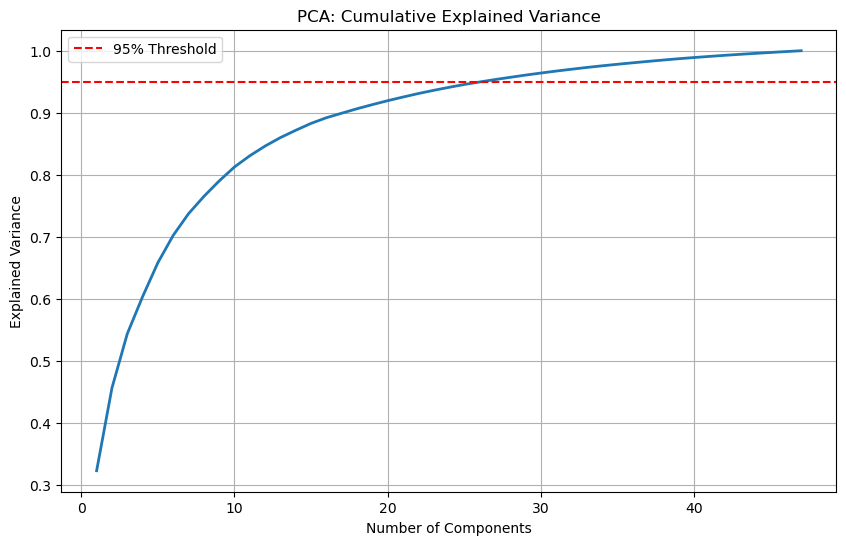


📊 Таблица объясненной дисперсии:
 Number of Components  Cumulative Explained Variance
                    1                       0.322987
                    2                       0.456315
                    3                       0.543650
                    4                       0.603536
                    5                       0.658348
                    6                       0.702375
                    7                       0.737287
                    8                       0.765078
                    9                       0.790074
                   10                       0.812625
                   11                       0.830671
                   12                       0.846322
                   13                       0.859972
                   14                       0.871749
                   15                       0.882883
                   16                       0.891984
                   17                       0.899289
            

In [40]:
# Применяем PCA
pca = PCA().fit(tag_embeddings)

# Накопленная объясненная дисперсия
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Пороги для оптимального количества компонент
thresholds = [0.80, 0.85, 0.90, 0.95]

# Определяем оптимальное количество компонент для порогов
optimal_components = {f"{int(threshold * 100)}%": np.argmax(explained_variance > threshold) + 1 for threshold in thresholds}

# Создаем DataFrame с результатами
df_variance = pd.DataFrame({
    "Number of Components": np.arange(1, len(explained_variance) + 1),
    "Cumulative Explained Variance": explained_variance
})

# Вывод графика
plt.figure(figsize=(10, 6))
plt.plot(df_variance['Number of Components'], df_variance['Cumulative Explained Variance'], lw=2)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("PCA: Cumulative Explained Variance")
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Вывод таблицы
print("\n📊 Таблица объясненной дисперсии:")
print(df_variance.head(20).to_string(index=False))  # Вывод первых 20 строк

# Вывод оптимальных значений
print("\n🔍 Оптимальное количество компонент для заданных порогов:")
for thresh, comp in optimal_components.items():
    print(f"Для {thresh} объясненной дисперсии достаточно: {comp} компонент")

In [41]:
# Удаление исходных текстовых колонок
data = data.drop(columns=['Negative_Review', 'Positive_Review'])

In [43]:
# Вынесем целевую колонку в начало для красоты
cols = list(data.columns)
cols.remove('Reviewer_Score')
cols.insert(0, 'Reviewer_Score')
len(cols)

134

In [44]:
data = data[cols]

Значения бинов: [-1.   -0.45  0.1   0.65  1.2   1.75  2.3   2.85  3.4   3.95  4.5   5.05
  5.6   6.15  6.7   7.25  7.8   8.35  8.9   9.45 10.  ]
Частоты в каждом бине: [103148      0      0      0      0      0   1759   3526   3298   4153
  11828   7817   9829  27249  20236  27902  59815  37549  47434 150195]


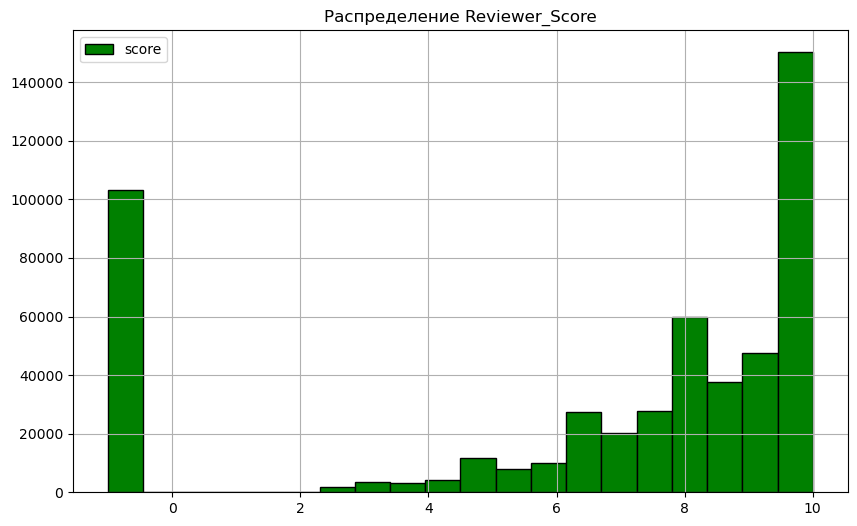

In [45]:
# Параметры графика
bins = 20
plt.rcParams["figure.figsize"] = (10, 6)

# Создание фигуры и осей
fig, ax = plt.subplots()

# Данные для построения гистограммы
x = data['Reviewer_Score'].values
n_x, bins_x = np.histogram(x, bins=bins)

# Вывод числовых данных
print("Значения бинов:", bins_x)
print("Частоты в каждом бине:", n_x)

# Настройка графика
ax.set(title="Распределение Reviewer_Score")
plt.hist(x, bins=bins, color='green', label="score", edgecolor='black')

# Добавление легенды и сетки
ax.legend()
ax.grid()

# Отображение графика
plt.show()

In [46]:
# Вытащим данные для сабмита
# Важно сохранить индекс!
data_to_submit = data[data['Reviewer_Score'] == -1].reset_index(drop = True)
data = data[data['Reviewer_Score'] != -1].reset_index(drop = True)

len(data_to_submit), len(data), data.shape

(103148, 412590, (412590, 134))

### Корреляция

In [47]:
# Шаг 0: Паттерны для исключения из корреляции
exclude_patterns = [
    'country_', 'tag_', 'is_', 'neg_', 'pos_', 
    'positive_keywords', 'negative_keywords', '_emb_', '_pca_', 'emb_'
]

# Шаг 1: Отбор числовых признаков без целевой переменной
numeric_cols = data.select_dtypes(include=['int', 'float']).columns.tolist()
if 'Reviewer_Score' in numeric_cols:
    numeric_cols.remove('Reviewer_Score')

# Шаг 2: Определение дополнительных признаков (без корреляции)
additional_cols = [
    col for col in data.columns 
    if (any(col.startswith(p) for p in exclude_patterns[:6]) or any(p in col for p in exclude_patterns[6:]))
    and col in data.select_dtypes(include=['int', 'float']).columns  # Убрал 'object' для consistency
]

# Шаг 3: Исключение additional_cols из анализа корреляции
numeric_cols_filtered = [col for col in numeric_cols if col not in additional_cols]

# Шаг 4: Расчёт корреляций с целевой переменной
corrs = []
for col in numeric_cols_filtered:
    try:
        cor = abs(data['Reviewer_Score'].corr(data[col]))
        if cor >= 0.015:  # Минимальный порог корреляции
            corrs.append((col, cor))
    except Exception as e:
        print(f"Ошибка при расчете корреляции для {col}: {e}")
        continue

# Шаг 5: Формирование итогового списка признаков
corr_df = pd.DataFrame(corrs, columns=['feature', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)

# Временное объединение перед удалением коррелирующих признаков
initial_features = list(set(corr_df['feature'].tolist() + additional_cols))

# Шаг 6: Удаление коррелирующих между собой признаков
def remove_correlated_features(df, features, threshold=0.8):
    """
    Удаляет коррелирующие признаки, сохраняя один признак из каждой коррелирующей группы
    
    Параметры:
        df: DataFrame с данными
        features: список признаков для анализа
        threshold: порог корреляции для удаления
    
    Возвращает:
        Список признаков после удаления коррелирующих
    """
    if not features:
        return features
        
    # Создаем корреляционную матрицу
    corr_matrix = df[features].corr().abs()
    
    # Верхний треугольник матрицы
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Находим признаки для удаления (корреляция > threshold)
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Сохраняем только некоррелирующие признаки
    selected_features = [feat for feat in features if feat not in to_drop]
    
    print(f"Удалено {len(to_drop)} коррелирующих признаков: {to_drop}")
    return selected_features

# Применяем функцию только к числовым признакам, не входящим в exclude_patterns
numeric_non_excluded = [col for col in initial_features 
                       if not any(col.startswith(p) for p in exclude_patterns)]

# Удаляем коррелирующие признаки
cols_non_correlated = remove_correlated_features(data, numeric_non_excluded, threshold=0.8)

# Объединяем с дополнительными признаками (которые не анализировались на корреляцию)
cols_to_train = list(set(cols_non_correlated + additional_cols))

# Шаг 7: Вывод результатов
print("\nТОП-10 признаков по корреляции с целевой переменной:")
print(corr_df.head(10).to_string(index=False))
print(f"\nВсего отобранных признаков: {len(cols_to_train )}")
print("\nСписок отобранных признаков:")
print(sorted(cols_to_train ))

Удалено 15 коррелирующих признаков: ['city_emb_3', 'Hotel_Name_emb_3', 'Hotel_Name_emb_7', 'city_emb_0', 'Additional_Number_of_Scoring', 'Hotel_Name_emb_1', 'lat', 'Hotel_Name_emb_4', 'Hotel_Name_emb_6', 'avg_word_count', 'Hotel_Name_emb_5', 'Review_quarter', 'Hotel_Name_emb_2', 'dist_to_center', 'negative_ratio']

ТОП-10 признаков по корреляции с целевой переменной:
                          feature  correlation
                   negative_ratio     0.561042
                   positive_ratio     0.561042
                sentiment_balance     0.466934
Review_Total_Negative_Word_Counts     0.383305
               combined_sentiment     0.317986
Review_Total_Positive_Word_Counts     0.220374
                   avg_word_count     0.168771
                   readability_nr     0.091637
          Total_Number_of_Reviews     0.073424
     Additional_Number_of_Scoring     0.062312

Всего отобранных признаков: 117

Список отобранных признаков:
['Hotel_Name_emb_0', 'Hotel_Name_emb_1', 'Hotel_Na

## Обучение моделей

### Подготовка данных

In [48]:
data_to_submit = data_to_submit[cols_to_train]
print(data_to_submit.shape)
data_to_submit.head(1)

(103148, 117)


,comb_emb_15,tag_pca_026,tag_pca_046,neg_4,Review_Total_Negative_Word_Counts,tag_pca_004,tag_pca_005,Hotel_Name_emb_0,tag_pca_020,comb_emb_3,...,tag_pca_008,Review_Total_Positive_Word_Counts,neg_6,reviewer_to_hotel_ratio,tag_pca_044,tag_pca_045,comb_emb_9,pos_6,tag_pca_000,tag_pca_002
0,0.866869,-0.018178,-0.002016,0.0,0,-0.108701,0.165422,-0.00015,-0.028546,0.515687,...,0.108504,14,0.0,0.004318,0.009075,0.009641,-0.177063,0.0,0.294618,-0.091335


In [49]:
skip_normalization = [
    'Reviewer_Score',
    *[col for col in data.columns if col.startswith(('country_', 'tag_', 'is_', 'neg_', 'pos_', 'positive_keywords', 'negative_keywords'))],
    *[col for col in data.columns if any(sub in col for sub in ['_emb_', '_tfidf_'])]
]

# 1. Формируем доступные признаки (cols_to_train должен быть определен ранее)
available_features = set(cols_to_train)

# 2. Фильтрация признаков
skip_normalization_filtered = [col for col in skip_normalization if col in available_features]
all_numeric_cols_filtered = data[cols_to_train].select_dtypes(include=['int', 'float']).columns.tolist()

# 3. Группы признаков для RobustScaler
to_robust = [
    col for col in all_numeric_cols_filtered 
    if col not in skip_normalization_filtered  # Исключаем признаки из skip_normalization
]

# 4. Проверка полноты признаков
used_features = set(to_robust + skip_normalization_filtered)
missing_features = set(cols_to_train) - used_features
if missing_features:
    print(f"Предупреждение: Не учтены признаки: {missing_features}")

# 5. Статистика
print(f"Признаки для RobustScaler: {len(to_robust)}")
print(to_robust)
print(f"Длина skip_normalization с учетом cols_to_train: {len(skip_normalization_filtered)}")
print(f"Всего использованных признаков: {len(used_features)}")
print(f"Разница: {len(used_features) - len(cols_to_train)}")

Признаки для RobustScaler: 12
['Review_Total_Negative_Word_Counts', 'lng', 'Total_Number_of_Reviews', 'center_lat', 'readability_pr', 'combined_sentiment', 'Review_month', 'sentiment_balance', 'readability_nr', 'positive_ratio', 'Review_Total_Positive_Word_Counts', 'reviewer_to_hotel_ratio']
Длина skip_normalization с учетом cols_to_train: 105
Всего использованных признаков: 117
Разница: 0


In [50]:
preprocessor = ColumnTransformer([
    ('robust', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Заполнение пропущенных значений медианой
        ('scaler', RobustScaler())                     # Масштабирование с использованием RobustScaler
    ]), to_robust)                                     # Применяем только к числам, не входящим в skip_normalization
], remainder='passthrough')                            # Оставляем skip_normalization без изменений

### Разделение на train/test

In [51]:
# Разделение на train/test

X = data[cols_to_train]
y = data['Reviewer_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_STATE
)

print("Подвыборка для быстрого тестирования:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Подвыборка для быстрого тестирования:
X_train: (371331, 117) y_train: (371331,)
X_test: (41259, 117) y_test: (41259,)


In [52]:
def mape_score(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(1e-8, np.abs(y_true)))) * 100

mape_scorer = make_scorer(mape_score, greater_is_better=False)

### Классические модели

#### LGBM

In [ ]:
start_time = time.time()

# Создаем pipeline с LGBM и правильным device
model_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(
        random_state=42,
        verbose=-1,
        device='cpu',
        # gpu_platform_id=0,
        # gpu_device_id=0,
        force_col_wise=True,
        #max_bin=255  
    ))
])

# Параметры для поиска (без gpu_platform_id и gpu_device_id)
param_distributions = {
     'regressor__num_leaves': IntDistribution(10, 36),
     'regressor__max_depth': IntDistribution(3, 24),  
     'regressor__learning_rate': FloatDistribution(0.01, 0.3),
     'regressor__n_estimators': IntDistribution(100, 900),
     'regressor__feature_fraction': FloatDistribution(0.6, 1.0),
     'regressor__min_data_in_leaf': IntDistribution(6, 120),
     'regressor__lambda_l1': FloatDistribution(0.0, 10.0),
     'regressor__lambda_l2': FloatDistribution(0.0, 10.0),
}

# Настройка OptunaSearchCV
optuna_search_lgbm = OptunaSearchCV(
    model_lgbm,
    param_distributions,
    cv=5,
    scoring=mape_scorer,
    n_trials=30,
    random_state=42,
    n_jobs=-1,  
    verbose=0
)

start_time = time.time()
print("\n🚀 Начинаем обучение LightGBM...")

try:
    optuna_search_lgbm.fit(X_train, y_train)

    if hasattr(optuna_search_lgbm, "best_estimator_"):
        best_model_lgbm = optuna_search_lgbm.best_estimator_
        train_pred = best_model_lgbm.predict(X_train)
        train_mape = mape_score(y_train, train_pred)

        print("\n✅ Результаты:")
        print(f"Лучшие параметры: {optuna_search_lgbm.best_params_}")
        print(f"MAPE на train: {train_mape:.4f}%")
    else:
        print("❌ Оптимизация не нашла подходящих параметров.")

except Exception as e:
    print(f"\n❌ Критическая ошибка: {str(e)}")
    print("Рекомендации:")
    print("1. Убедитесь, что данные корректны и нет Inf/NaN")
    print("2. Попробуйте использовать device='cpu'")
    print("3. Убедитесь, что max_bin <= 255 при использовании GPU")
finally:
    print(f"\n🕒 Общее время выполнения: {time.time() - start_time:.2f} секунд")


🚀 Начинаем обучение LightGBM...


  File "c:\Users\Andrey\anaconda3\envs\reviews-env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Andrey\anaconda3\envs\reviews-env\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Andrey\anaconda3\envs\reviews-env\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Andrey\anaconda3\envs\reviews-env\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



✅ Результаты:
Лучшие параметры: {'regressor__num_leaves': 27, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.08554088561363478, 'regressor__n_estimators': 461, 'regressor__feature_fraction': 0.9418096096048945, 'regressor__min_data_in_leaf': 76, 'regressor__lambda_l1': 9.24231868443772, 'regressor__lambda_l2': 7.832750305082568}
MAPE на train: 7.6539%

🕒 Общее время выполнения: 529.81 секунд


#### XGBoost

In [55]:
start_time = time.time()

# Создаем pipeline с XGBoost на GPU
model_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        random_state=42,
        tree_method='hist',  # Используем GPU
        device='cuda', # cuda
        enable_categorical=False,
        verbosity=0
    ))
])

# Параметры для Optuna (адаптированные для XGBoost)
param_distributions = {
    'regressor__max_depth': IntDistribution(3, 16),
    'regressor__learning_rate': FloatDistribution(0.05, 0.3),
    'regressor__n_estimators': IntDistribution(100, 700),
    'regressor__subsample': FloatDistribution(0.7, 1.0),
    'regressor__colsample_bytree': FloatDistribution(0.7, 1.0),
    'regressor__min_child_weight': IntDistribution(5, 22),
    'regressor__gamma': FloatDistribution(0, 6),
    'regressor__reg_alpha': FloatDistribution(1e-4, 10.0, log=True),
    'regressor__reg_lambda': FloatDistribution(1e-4, 10.0, log=True),
    'regressor__grow_policy': CategoricalDistribution(['depthwise', 'lossguide'])
}


# Предсказание и оценка
# Настройка OptunaSearchCV
optuna_search_xgb = OptunaSearchCV(
    model_xgb,
    param_distributions,
    cv=5,
    scoring=mape_scorer,
    n_trials=30,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("\n🚀 Начинаем обучение XGBoost...")

try:
    optuna_search_xgb.fit(X_train, y_train)

    if hasattr(optuna_search_xgb, "best_estimator_"):
        best_model_xgb = optuna_search_xgb.best_estimator_
        train_pred = best_model_xgb.predict(X_train)
        train_mape = mape_score(y_train, train_pred)
        elapsed_time = time.time() - start_time

        # Вывод результатов
        print(f"Лучшие параметры: {optuna_search_xgb.best_params_}")
    else:
        print("❌ Оптимизация не нашла подходящих параметров.")
        train_mape = None
        elapsed_time = time.time() - start_time

except Exception as e:
    print(f"\n❌ Критическая ошибка: {str(e)}")
    train_mape = None
    elapsed_time = time.time() - start_time

print(f"MAPE на train: {train_mape:.4f}%" if train_mape is not None else "MAPE на train: ошибка")
print(f"Время выполнения: {elapsed_time:.2f} секунд")
print(f"MAPE на train: {train_mape:.4f}%")
print(f"Время выполнения: {elapsed_time:.2f} секунд")


🚀 Начинаем обучение XGBoost...
Лучшие параметры: {'regressor__max_depth': 5, 'regressor__learning_rate': 0.058063193549455744, 'regressor__n_estimators': 491, 'regressor__subsample': 0.9364551968535951, 'regressor__colsample_bytree': 0.9072383904028419, 'regressor__min_child_weight': 16, 'regressor__gamma': 1.5192495745821084, 'regressor__reg_alpha': 0.5729514360676158, 'regressor__reg_lambda': 0.005019907919782723, 'regressor__grow_policy': 'lossguide'}
MAPE на train: 7.6640%
Время выполнения: 2509.42 секунд
MAPE на train: 7.6640%
Время выполнения: 2509.42 секунд


In [56]:
# Выбираем лучшую модель на основе тестовых данных
models = {
    "LGBMRegressor": optuna_search_lgbm.best_estimator_,
    "XGBRegressor": optuna_search_xgb.best_estimator_,
         
}

In [66]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

results = {}
for model_name, model in models.items():
    model.fit(X_train_split, y_train_split)
    val_pred = model.predict(X_val)
    val_mape = mape_score(y_val, val_pred)
    results[model_name] = val_mape
    print(f"MAPE на валидации для {model_name}: {val_mape:.2f}%")

best_model_name = min(results, key=results.get)
print(f"\nЛучшая модель: {best_model_name} с MAPE на валидации: {results[best_model_name]:.2f}%")

MAPE на валидации для LGBMRegressor: 7.90%
MAPE на валидации для XGBRegressor: 7.90%

Лучшая модель: XGBRegressor с MAPE на валидации: 7.90%


In [58]:
def plot_top_features(model, model_name, feature_names, top_n=20):
    """
    Строит график топ-N важных признаков для модели
    
    Параметры:
    model - обученная модель
    model_name - название модели для заголовка
    feature_names - список названий признаков
    top_n - количество отображаемых признаков
    """
    # Получаем важности признаков с учетом типа модели
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        importances = model.get_feature_importance()
    else:
        raise ValueError("Модель не поддерживает получение важности признаков")
    
    # Создаем Series с правильными названиями признаков
    feat_importances = pd.Series(importances, index=feature_names)
    
    # Берем топ-N признаков
    top_features = feat_importances.nlargest(top_n)
    
    # Строим график
    plt.figure(figsize=(10, 5))
    top_features.plot(kind='barh')
    plt.title(f'Top {top_n} Feature Importances for {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()   


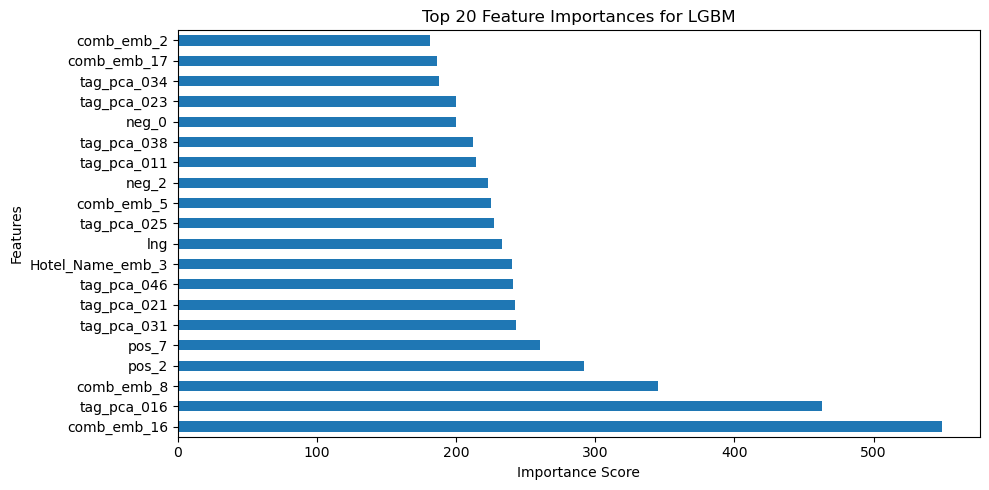

In [59]:
plot_top_features(best_model_lgbm.named_steps['regressor'], 'LGBM', cols_to_train, top_n=20)

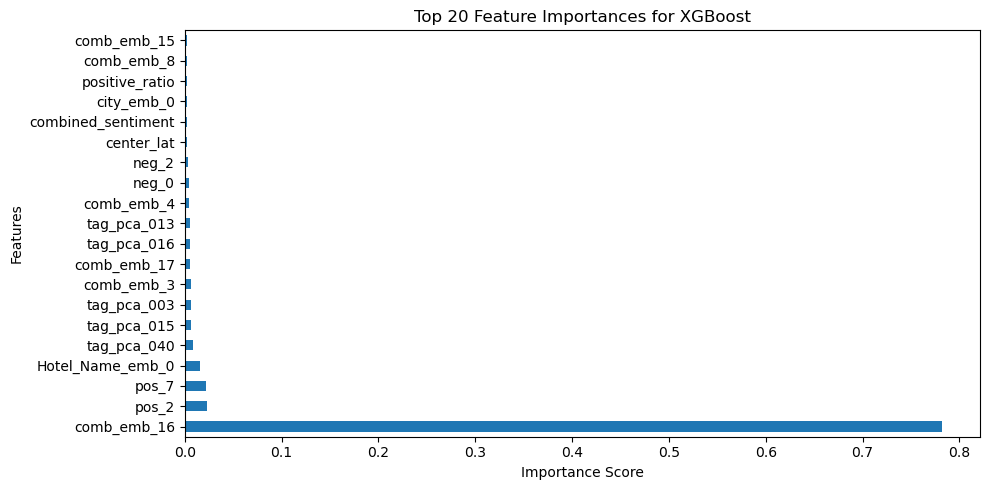

In [60]:
 # Для XGBoost
plot_top_features(best_model_xgb.named_steps['regressor'], 'XGBoost', cols_to_train, top_n=20)

## Сабмит 

In [78]:
model = optuna_search_xgb.best_estimator_


In [79]:
%%time

predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

CPU times: total: 2.52 s
Wall time: 451 ms


In [80]:
print(f"Качество train: {round(mape_score(y_train, predict_train), 3)}")
print(f"Качество CV: {round(mape_score(y_train, predict_train_cv), 3)}")
print(f"Качество test: {round(mape_score(y_test, predict_test), 3)}")
print(f"\nЛучшая модель: {best_model_name} с MAPE на валидации: {results[best_model_name]:.2f}%")

Качество train: 7.674
Качество CV: 7.907
Качество test: 9.426

Лучшая модель: XGBRegressor с MAPE на валидации: 7.90%


In [81]:
def postprocess_predictions(y_pred):
    y_pred = np.clip(y_pred, 2.5, 10.0)
    return np.round(y_pred, 1)  # Округляем до одного знака после запятой

predict_submit = model.predict(data_to_submit)
predict_submit_clipped = postprocess_predictions(predict_submit)  
print(len(predict_submit_clipped))
predict_submit_clipped

103148


array([9.2, 8.7, 7.1, ..., 9.6, 9.9, 9.5], dtype=float32)

In [76]:
res = pd.DataFrame()
res['prediction'] = predict_submit_clipped
res['id'] = res.index

res = res[['id', 'prediction']]
res.head()

,id,prediction
0,0,9.2
1,1,8.7
2,2,7.1
3,3,9.8
4,4,8.8


In [77]:
res.to_csv('submission.csv', index = False)